In [311]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [312]:
#Parameters
trading_window = 15

#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [313]:
dataimport=pd.read_csv('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/data/Indexes/SP GLOBAL 100.csv')
datacopy1 = dataimport.copy()
dataimport['Date'] = pd.to_datetime(dataimport['Date'])
curr = dataimport.columns[0]
dataimport.rename(columns={curr: 'Stocks'}, inplace=True)
dataimport.set_index('Stocks', inplace=True)

#data = dataimport.resample('M').first()  #Monthly Resampling



#dataimport.head()

In [314]:

def first_last_diff(x):
    return ((x.iloc[-1] - x.iloc[0])/x.iloc[0])
monthly = dataimport[dataimport.columns].resample('M').agg(first_last_diff)
#monthly.head()

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_63398/4092033251.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = dataimport[dataimport.columns].resample('M').agg(first_last_diff)


In [315]:
data = dataimport.transpose()
#data.head()

In [316]:
train_data = monthly.iloc[:12]  

for i in train_data.columns:
    train_data[i] = (1 + train_data[i]).cumprod() - 1

train_data=train_data.transpose()
#train_data

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_63398/368789790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[i] = (1 + train_data[i]).cumprod() - 1


In [317]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(train_data)
labels = ap.predict(train_data)

In [318]:
groups = []
for i in range(labels.max()+1):
    arr = []
    for j in range(len(labels)):
        if labels[j] == i:
            arr.append(train_data.index[j])
    groups.append(arr)


for i in range(len(groups)):
    print("Group", i+1, ":", groups[i])

Group 1 : ['OR FP Equity', 'ASML NA Equity', 'MRK UN Equity', 'TTE FP Equity', 'MSFT UW Equity', 'MC FP Equity', 'GOOGL UW Equity', 'NESN SE Equity', 'NOVN SE Equity', 'SREN SE Equity', 'BAYN GY Equity', 'BAS GY Equity', 'MUV2 GY Equity', 'BP/ LN Equity']
Group 2 : ['CAT UN Equity', 'MMM UN Equity', 'RTX UN Equity', '5108 JT Equity', 'TMO UN Equity', '700 HK Equity', 'AON UN Equity', 'DTE GY Equity', 'PRU LN Equity']
Group 3 : ['NVDA UW Equity']
Group 4 : ['AAL LN Equity', 'HPQ UN Equity', '6752 JT Equity', 'PHIA NA Equity', '6758 JT Equity', '8306 JT Equity', 'C UN Equity', 'GS UN Equity', 'F UN Equity', 'RWE GY Equity', 'MS UN Equity']
Group 5 : ['CVX UN Equity', 'AMZN UW Equity', 'IBM UN Equity', 'MCD UN Equity', 'INTC UW Equity', 'NG/ LN Equity', 'ABT UN Equity', 'JCI UN Equity', 'GSK LN Equity', 'BMY UN Equity', 'AAPL UW Equity', 'CL UN Equity', 'KMB UN Equity', 'LLY UN Equity', 'MMC UN Equity']
Group 6 : ['JPM UN Equity', 'GE UN Equity', 'BBVA SQ Equity', 'SAN SQ Equity', 'CS FP 

# Indicators

In [319]:

datacopy1['Date'] = pd.to_datetime(datacopy1['Date'])
datacopy1.set_index('Date', inplace=True)
data = datacopy1.resample('M').first()  # Weekly Resampling

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

#data

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_63398/3470200961.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = datacopy1.resample('M').first()  # Weekly Resampling


In [320]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [321]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
#master_macd

In [322]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [323]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
#master_rsi

In [324]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
#prices

#  strat1 RSI+MACD fixed exit strat

In [325]:
def get_returns(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            n = 0
            temp = 0

        i += 1

    return returns,num_trades

In [326]:
returns,num_trades = get_returns(groups,master_macd,master_rsi,prices,trading_window)

In [327]:
tradesheet1 = pd.DataFrame()
tradesheet1['Returns'] = returns
tradesheet1['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet1.insert(0,f'Window (period = {trading_window})',windows)
tradesheet1

,Window (period = 15),Returns,Number of Trades
0,1,-7212.881328,8
1,2,154.075197,8
2,3,1032.281444,23
3,4,31.863908,16
4,5,-615.360246,21
5,6,-2871.921351,17
6,7,2631.915411,12
7,8,2012.820099,17


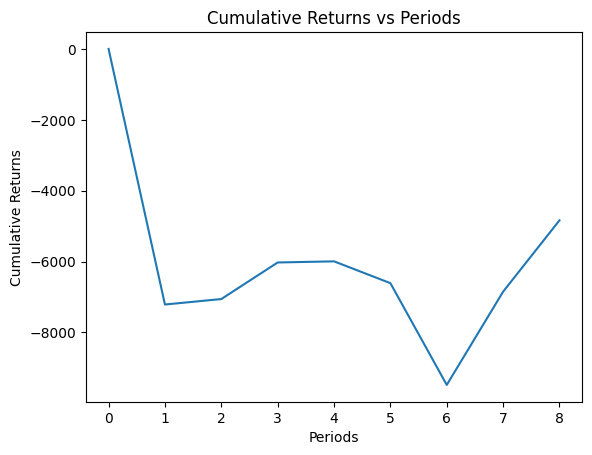

In [328]:
cumulative_returns_1 = []
cumulative_returns_1.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_1.append(s)


plt.plot(windows,cumulative_returns_1)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


# Strat-2 with variable exit in window + fixed exit at the end

In [329]:
def get_returns_2(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
            
            elif(buy!=0):
                for trade in intrade:
                    if(trade[3]==buy):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        temp += (((b2-b1))*trade[2]) + ((s1-s2))
                        intrade.remove(trade)
                        n += 1


            elif(sell!=0):
                for trade in intrade:
                    if(trade[1]==sell):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        temp += (((b2-b1))*trade[2]) + ((s1-s2))
                        intrade.remove(trade)
                        n += 1 
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            temp = 0
            n = 0

        i += 1

    return returns,num_trades

In [330]:
returns,num_trades = get_returns_2(groups,master_macd,master_rsi,prices,trading_window)

In [331]:
tradesheet2 = pd.DataFrame()
tradesheet2['Returns'] = returns
tradesheet2['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet2.insert(0,f'Window (period = {trading_window})',windows)
tradesheet2

,Window (period = 15),Returns,Number of Trades
0,1,-7211.347826,8
1,2,155.666305,8
2,3,979.723121,23
3,4,10.678653,16
4,5,-690.510449,21
5,6,-838.954409,17
6,7,2705.032410,12
7,8,2037.717924,17


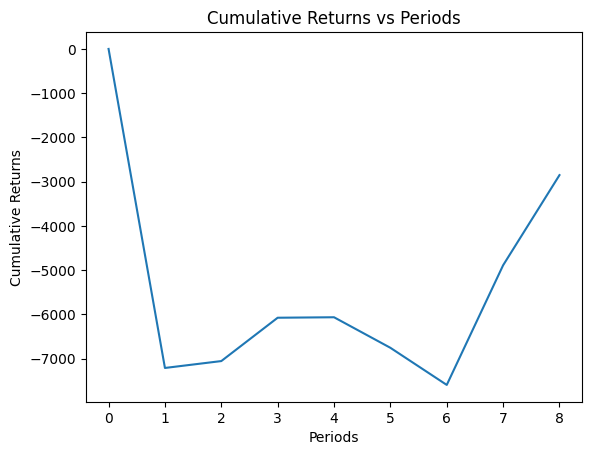

In [332]:

cumulative_returns_2 = []
cumulative_returns_2.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_2.append(s)


plt.plot(windows,cumulative_returns_2)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


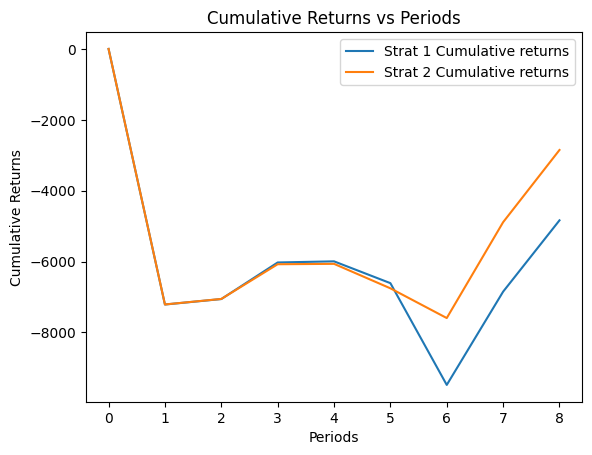

In [333]:
plt.plot(windows,cumulative_returns_1,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_2,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/plots/with clustering/monthly/SP GLOBAL 100_macd_rsi.png')
plt.show()

# strat 3 RSI Fixed exit

In [334]:
def get_returns(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades

In [335]:
returns,num_trades = get_returns(groups,master_rsi,prices,trading_window)

In [336]:
tradesheet3 = pd.DataFrame()
tradesheet3['Returns'] = returns
tradesheet3['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet3.insert(0,f'Window (period = {trading_window})',windows)
tradesheet3

,Window (period = 15),Returns,Number of Trades
0,1,-18790.522763,3
1,2,0.000000,0
2,3,-2210.921039,7
3,4,51.562829,1
4,5,-67.012713,5
5,6,-36.642032,1
6,7,-339.016574,6
7,8,29009.418474,2


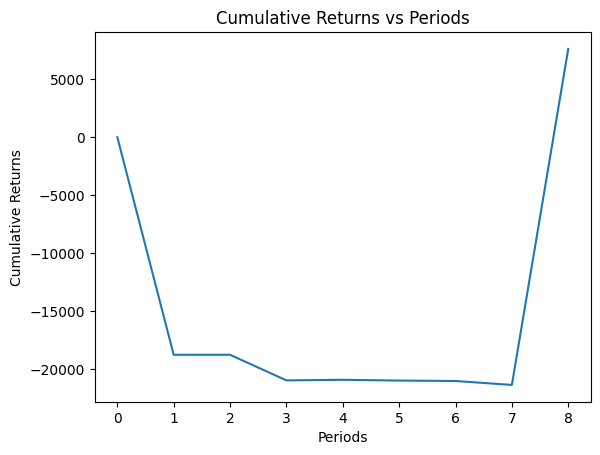

In [337]:
cumulative_returns_3 = []
cumulative_returns_3.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_3.append(s)


plt.plot(windows,cumulative_returns_3)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

# strat 4 RSI variable exit

In [338]:
def get_returns(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades

In [339]:
tradesheet4 = pd.DataFrame()
tradesheet4['Returns'] = returns
tradesheet4['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet4.insert(0,f'Window (period = {trading_window})',windows)
tradesheet4

,Window (period = 15),Returns,Number of Trades
0,1,-18790.522763,3
1,2,0.000000,0
2,3,-2210.921039,7
3,4,51.562829,1
4,5,-67.012713,5
5,6,-36.642032,1
6,7,-339.016574,6
7,8,29009.418474,2


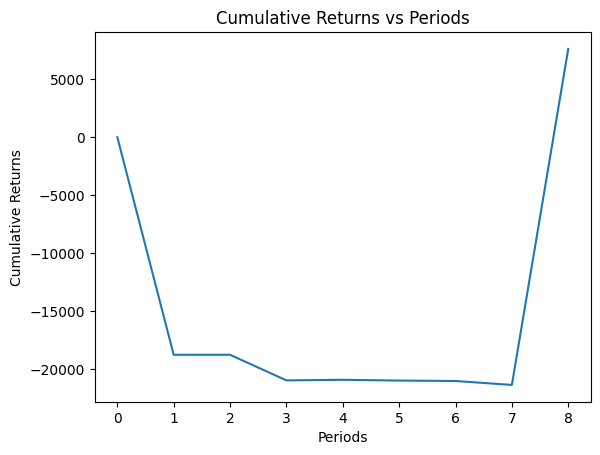

In [340]:
cumulative_returns_4 = []
cumulative_returns_4.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_4.append(s)


plt.plot(windows,cumulative_returns_4)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

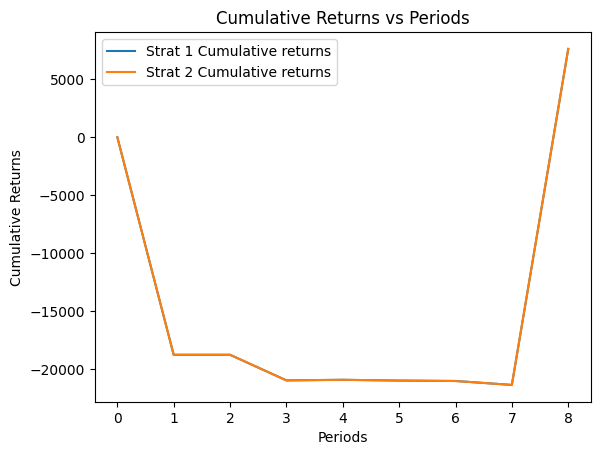

In [341]:
plt.plot(windows,cumulative_returns_3,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_4,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/plots/with clustering/monthly/SP GLOBAL 100_rsi.png')
plt.show()
